# Imports and data loading

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
catalog = pd.read_csv('data/data_catalogue.csv')
data = pd.read_csv('data/data_arena_members.csv')

# Utils

In [3]:
def plot_hist2d(x,
                y,
                title,
                xlabel,
                ylabel,
                ax,
                bins=(50,50),
                cmap=plt.cm.BuPu):
    ax.hist2d(x, y, bins=bins, cmap=cmap)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
def price_ditributions(catalog,
                       price='creds'):
    if not price in ['creds', 'gold']:
        raise ValueError('Can display only creds and gold distibutions!')
    fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(16,30))
    for i, ax in enumerate(axs.flat):
        ax.set_title(f'Level {i + 1}')
        sns.distplot(catalog[catalog['item_level']==i+1]['item_price_credit' if price=='creds' else 'item_price_gold'].values,
                     kde=i!=0 and i!=9, bins=15, ax=ax)
    plt.show()
    
def get_regression_line(x,
                        y,
                        degree):
    params = np.polyfit(x, y, degree)
    poly = np.poly1d(params)
    x_grid = np.linspace(min(x), max(x), 100)
    y_grid = poly(x_grid)
    return x_grid, y_grid

def build_model(inputs):
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[inputs]),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)
    loss = tf.keras.losses.MSE

    model.compile(loss=loss,
                  optimizer=optimizer)
    return model

def plot_history(model):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
        
    plt.plot(hist['epoch'], hist['loss'], label='Train loss')
    plt.plot(hist['epoch'], hist['val_loss'], label='Val loss')
        
    plt.ylim([0,1])
    plt.legend()

    plt.show()

# Catalog cleaning

In [4]:
removed_tanks = pd.DataFrame()

masks = [
    ('cleaning by crew_size: 2 <= crew_size <= 6', \
    (catalog['crew_size'] >= 2) & (catalog['crew_size'] <= 6)),
    
    ('cleaning by 1 level: item_price_credit = item_price_gold = 0', \
    (catalog['item_level'] != 1) | \
    ((catalog['item_price_credit'] == 0) & (catalog['item_price_gold'] == 0))),
    
    ('cleaning by price: item_price_credit > 100 or item_price_gold > 100', \
    (catalog['item_level'] == 1) | \
    (((catalog['item_price_credit'] > 100) & (catalog['item_price_gold'] == 0)) | \
    ((catalog['item_price_credit'] == 0) & (catalog['item_price_gold'] > 100)))),
    
    ('custom cleaning by price 2 level: 2000 < item_price_credit < 20000', \
    (catalog['item_level'] != 2) | (catalog['item_price_gold'] != 0) | \
    (catalog['item_price_credit'] > 2000) & (catalog['item_price_credit'] < 20000)),
    
    ('custom cleaning by price 5 level: item_price_credit < 500000', \
    (catalog['item_level'] != 5) | \
    (catalog['item_price_gold'] != 0) | (catalog['item_price_credit'] < 500000))
]

for mask in masks:
    N = len(catalog)
    
    removed_tanks = pd.concat([removed_tanks, catalog.loc[~mask[1]]])
    catalog = catalog.loc[mask[1]]

    print(f'[{mask[0].upper()}]: removed {N - len(catalog)} rows. ({100 * (1 - len(catalog) / N)} %)')
    
catalog.index = np.arange(len(catalog))
removed_tanks.index = np.arange(len(removed_tanks))

print(f'\nTotally removed {len(removed_tanks)} rows. ({100 * len(removed_tanks) / (len(removed_tanks) + len(catalog))} %)')

[CLEANING BY CREW_SIZE: 2 <= CREW_SIZE <= 6]: removed 7 rows. (0.7882882882882858 %)
[CLEANING BY 1 LEVEL: ITEM_PRICE_CREDIT = ITEM_PRICE_GOLD = 0]: removed 9 rows. (1.0215664018161208 %)
[CLEANING BY PRICE: ITEM_PRICE_CREDIT > 100 OR ITEM_PRICE_GOLD > 100]: removed 98 rows. (11.238532110091748 %)
[CUSTOM CLEANING BY PRICE 2 LEVEL: 2000 < ITEM_PRICE_CREDIT < 20000]: removed 20 rows. (2.5839793281653756 %)
[CUSTOM CLEANING BY PRICE 5 LEVEL: ITEM_PRICE_CREDIT < 500000]: removed 1 rows. (0.13262599469495706 %)

Totally removed 135 rows. (15.202702702702704 %)


In [5]:
for feature in ['item_cd']:
    catalog[feature] = pd.Categorical(catalog[feature])

classEncoder = LabelEncoder()
catalog['item_class'] = classEncoder.fit_transform(catalog['item_class'])
catalog

,item_cd,item_class,item_price_credit,item_price_gold,item_level,crew_size
0,1,4,356700,0,5,4
1,17,4,373000,0,5,5
2,33,2,0,1500,5,5
3,49,4,0,7500,8,4
4,81,4,0,0,1,5
...,...,...,...,...,...,...
748,64817,3,0,3500,6,5
749,65041,1,0,0,1,6
750,65073,2,0,12250,8,4
751,65297,2,0,12500,8,5


In [6]:
print(f'Catalog shape: {catalog.shape}\n')
print(f'Duplicates num: {catalog.duplicated().sum()}\n')
print(f'NaN num:\n{catalog.isnull().sum()}')

catalog.info()

Catalog shape: (753, 6)

Duplicates num: 0

NaN num:
item_cd              0
item_class           0
item_price_credit    0
item_price_gold      0
item_level           0
crew_size            0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 753 entries, 0 to 752
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   item_cd            753 non-null    category
 1   item_class         753 non-null    int32   
 2   item_price_credit  753 non-null    int64   
 3   item_price_gold    753 non-null    int64   
 4   item_level         753 non-null    int64   
 5   crew_size          753 non-null    int64   
dtypes: category(1), int32(1), int64(4)
memory usage: 59.7 KB


In [7]:
s1 = set(removed_tanks['item_cd'])
s2 = set(data['vehicle_type_cd'])

removed_ids = s1.intersection(s2)

print(removed_ids)

{6225, 13889, 9297, 65281}


# Catalog visualizing

In [ ]:
creds_catalog = catalog[catalog['item_price_gold'] == 0]
gold_catalog = catalog[catalog['item_price_credit'] == 0]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16,5))

degree = 3
prices = creds_catalog[['item_level', 'item_price_credit']].values

plot_hist2d(x=creds_catalog['item_level'],
            y=creds_catalog['item_price_credit'],
            title='Price credits distribution by level',
            xlabel='Level',
            ylabel='Price credits',
            ax=axs[0])
axs[0].plot(*get_regression_line(prices[:,0], prices[:,1], degree), '-r')

degree = 3
prices = gold_catalog[['item_level', 'item_price_gold']].values

plot_hist2d(x=gold_catalog['item_level'],
            y=gold_catalog['item_price_gold'],
            title='Price gold distribution by level',
            xlabel='Level',
            ylabel='Price gold',
            ax=axs[1])
axs[1].plot(*get_regression_line(prices[:,0], prices[:,1], degree), '-r')

plt.show()

In [ ]:
price_ditributions(creds_catalog, price='creds')

In [ ]:
price_ditributions(gold_catalog, price='gold')

In [ ]:
sns.countplot(classEncoder.inverse_transform(catalog['item_class']));

In [ ]:
sns.countplot(catalog['item_level']);

In [ ]:
sns.countplot(catalog['crew_size']);

# Arenas data cleaning

In [8]:
N0 = len(data)

masks = [
    ('sync with catalog: vehicle_type_cd not in removed_ids', \
    ~data['vehicle_type_cd'].isin(removed_ids))
]

for mask in masks:
    N = len(data)
    
    data = data.loc[mask[1]]

    print(f'[{mask[0].upper()}]: removed {N - len(data)} rows. ({100 * (1 - len(data) / N)} %)')
    
data.index = np.arange(len(data))

print(f'\nTotally removed {N0 - len(data)} rows. ({100 * (1 - len(data) / N0)} %)')

[SYNC WITH CATALOG: VEHICLE_TYPE_CD NOT IN REMOVED_IDS]: removed 447 rows. (0.03185110499107635 %)

Totally removed 447 rows. (0.03185110499107635 %)


In [9]:
for feature in ['clan_db_id', 'is_prebattle_creator']:
    data[feature] = pd.Categorical(data[feature])

data['dt'] = pd.to_datetime(data['dt'])

In [ ]:
print(f'Catalog shape: {data.shape}\n')
print(f'Duplicates num: {data.duplicated().sum()}\n')
print(f'NaN num:\n{data.isnull().sum()}')

data.info()

# Restoring winrates

In [10]:
def calc_winner(row):
    winner = 0
    if row['num_tanks_pos_1'] != 0 and row['num_tanks_pos_2'] == 0:
        winner = 1
    elif row['num_tanks_pos_2'] != 0 and row['num_tanks_pos_1'] == 0:
        winner = 2
    else:
        if row['mean_xp_1'] / row['mean_xp_2'] > 1.8:
            winner = 1
        elif row['mean_xp_2'] / row['mean_xp_1'] > 1.8:
            winner = 2
        else:
            winner = 0     
    return winner

data['is_alive'] = data['remained_hp'] > 0

print('[FILTERING DATA FOR FULL 15x15 TEAMS...]', end='  ')
warriors = data[data.groupby('arena_id')['account_db_id'].transform('count') == 30]
warriors.index = np.arange(len(warriors))
print(f'[FILTERED]: removed {len(data) - len(warriors)} rows!')
    
print('[GROUPING BATTLES AND TEAMS...]', end='  ')
battles = warriors.groupby(['arena_id', 'team_id'])
print(f'[GROUPED BATTLES AND TEAMS]: There are {sum(battles["account_db_id"].count() != 15)} not full teams!')

print('[CALCULATING STATS...]', end='  ')
info_df = pd.DataFrame(index = [ind[0] for ind in battles.count().index][::2])
info_df['num_tanks_pos_1'] = battles['is_alive'].sum().iloc[::2].values
info_df['num_tanks_pos_2'] = battles['is_alive'].sum().iloc[1::2].values
info_df['mean_xp_1'] = battles['original_xp'].mean().iloc[::2].values
info_df['mean_xp_2'] = battles['original_xp'].mean().iloc[1::2].values
print(f'[CALCULATED STATS]: There are {len(battles) // 2} restored battles!')
    
print('[CALCULATING WINNERS...]', end='  ')
info_df['winner_team_id'] = info_df.apply(calc_winner, axis=1)
print('[CALCULATED WINNERS]')
    
print('[JOINING...]', end='  ')
info_df.reset_index(inplace=True)
data = data.merge(info_df[['index', 'winner_team_id']], how='left', left_on='arena_id', right_on='index')
data.drop(columns=['index'], inplace=True, axis=1)
print('[JOINED]')

data['is_winner'] = data['team_id'] == data['winner_team_id']

[FILTERING DATA FOR FULL 15x15 TEAMS...]  [FILTERED]: removed 38588 rows!
[GROUPING BATTLES AND TEAMS...]  [GROUPED BATTLES AND TEAMS]: There are 0 not full teams!
[CALCULATING STATS...]  [CALCULATED STATS]: There are 45479 restored battles!
[CALCULATING WINNERS...]  [CALCULATED WINNERS]
[JOINING...]  [JOINED]


In [11]:
players_for_train = data[data.groupby('account_db_id')['account_db_id'].transform('count') >= 10]
players_for_train = players_for_train.groupby('account_db_id').agg({'original_xp' : 'median',
                                                                    'is_winner' : lambda g: sum(g) / len(g)})
players_for_train.columns = ['median_original_xp', 'player_winrate']

players_for_train

,median_original_xp,player_winrate
account_db_id,,
c21114Naa,597.0,0.538462
c2111Ncyd,1385.0,0.488372
c2111TTa7,208.5,0.200000
c2111d217,1411.0,0.625000
c211212c4,525.0,0.533333
...,...,...
cyyyyTcy4,383.0,0.347826
cyyyya77a,867.0,0.312500
cyyyyd71y,1149.5,0.500000


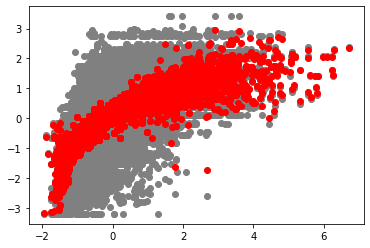

0.543498303218793

In [12]:
players_xp_scaler, players_winrate_sc = StandardScaler(), StandardScaler()

Xn = players_xp_scaler.fit_transform(players_for_train[['median_original_xp']])
Yn = players_winrate_sc.fit_transform(players_for_train[['player_winrate']])

model = GradientBoostingRegressor(n_estimators=600, max_depth=8)
model.fit(Xn, Yn.reshape(len(Yn),))

preds = model.predict(Xn)

plt.scatter(Xn, Yn,  color='gray')
plt.scatter(Xn, preds, color='red')
plt.show()

mean_squared_error(Yn, preds)

In [13]:
players_data = data.groupby('account_db_id').agg({'original_xp' : 'median',
                                                  'is_winner' : lambda g: sum(g) / len(g)})
players_data.columns = ['median_original_xp', 'player_winrate']

players_data

,median_original_xp,player_winrate
account_db_id,,
c2111224a,828.0,0.00
c211122N4,797.0,0.00
c21112TT1,267.0,0.25
c21112aa2,1943.0,1.00
c21112yNT,755.0,1.00
...,...,...
cyyyyyT74,797.5,0.50
cyyyyya7c,1379.5,0.50
cyyyyyd1a,221.0,0.00


In [14]:
players_xp_normed = players_xp_scaler.transform(players_data[['median_original_xp']])
players_winrate_normed = model.predict(players_xp_normed)
players_data['player_winrate_ML'] = players_winrate_sc.inverse_transform(players_winrate_normed)

players_data

,median_original_xp,player_winrate,player_winrate_ML
account_db_id,,,
c2111224a,828.0,0.00,0.494078
c211122N4,797.0,0.00,0.483453
c21112TT1,267.0,0.25,0.318956
c21112aa2,1943.0,1.00,0.668489
c21112yNT,755.0,1.00,0.482578
...,...,...,...
cyyyyyT74,797.5,0.50,0.528081
cyyyyya7c,1379.5,0.50,0.581626
cyyyyyd1a,221.0,0.00,0.181570


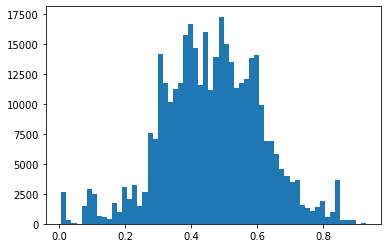

0.46271966790567187

In [15]:
plt.hist(players_data['player_winrate_ML'], bins=60)
plt.show()

players_data['player_winrate_ML'].mean()

In [16]:
data = data.merge(players_data[['player_winrate_ML']], how='left', on='account_db_id')
data

,dt,arena_id,account_db_id,team_id,clan_db_id,prebattle_id,is_prebattle_creator,vehicle_type_cd,life_time_sec,shots,...,premium_xp_factor,daily_xp_factor,battle_num,damage_blocked_by_armor,booster_bonus_credits,booster_bonus_xp,is_alive,winner_team_id,is_winner,player_winrate_ML
0,2018-10-27,4yNy14y4yN12d42dT,c42c4aydT,2,0,0,0,2849,132,3,...,15,20,11956,0,0,0,False,2.0,True,0.203866
1,2018-10-27,4yNy14y4yN12d42dT,c2TaaayN4,1,500033550,0,0,63553,195,6,...,15,10,9832,0,0,0,False,2.0,False,0.402422
2,2018-10-27,4yNy14y4yN12d42dT,cyyd47dc4,2,500051107,67896661,0,17665,224,11,...,15,20,39190,0,0,1130,False,2.0,True,0.579576
3,2018-10-27,4yNy14y4yN12d42dT,c2cdc441y,2,0,0,0,11537,381,8,...,15,20,7217,0,0,0,True,2.0,True,0.488318
4,2018-10-27,4yNy14y4yN12d42dT,cdT7cTT21,1,0,0,0,7937,198,5,...,15,10,9532,0,0,0,False,2.0,False,0.497079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1402953,2018-10-11,1ccdcTcya4T7Nyc,cac4aa12N,2,500150344,5640480,0,1921,364,9,...,15,20,13638,0,0,0,True,NaN,False,0.410263
1402954,2018-10-11,1ccdcTcya4T7Nyc,cdTcc72Nc,1,500138824,5288203,0,913,311,6,...,15,10,14741,760,0,0,False,NaN,False,0.375367
1402955,2018-10-11,1ccdcTcya4T7Nyc,cd42c2TTT,1,500154303,5288203,0,50193,174,2,...,15,10,29797,0,0,0,False,NaN,False,0.502854
1402956,2018-10-11,1ccdcTcya4T7Nyc,cd4a7Tc72,2,500156478,5640480,0,51361,136,7,...,15,10,41982,0,0,0,False,NaN,False,0.411648


In [17]:
N0 = len(data)

masks = [
    ('cleaning by tank battles: vehicle_type_cd.grouped.count >= 100', \
    data.groupby('vehicle_type_cd')['vehicle_type_cd'].transform('count') >= 100)
]

for mask in masks:
    N = len(data)
    
    data = data.loc[mask[1]]

    print(f'[{mask[0].upper()}]: removed {N - len(data)} rows. ({100 * (1 - len(data) / N)} %)')
    
data.index = np.arange(len(data))

print(f'\nTotally removed {N0 - len(data)} rows. ({100 * (1 - len(data) / N0)} %)')

[CLEANING BY TANK BATTLES: VEHICLE_TYPE_CD.GROUPED.COUNT >= 100]: removed 2468 rows. (0.1759140330644282 %)

Totally removed 2468 rows. (0.1759140330644282 %)


In [18]:
tanks_data = data.groupby('vehicle_type_cd').agg({'original_xp' : 'median',
                                                  'is_winner' : lambda g: sum(g) / len(g)})
tanks_data.columns = ['median_original_xp', 'tank_winrate']

tanks_data

,median_original_xp,tank_winrate
vehicle_type_cd,,
49,854.0,0.491997
273,412.0,0.463068
305,773.0,0.529582
513,504.0,0.492171
529,433.0,0.468172
...,...,...
64065,830.0,0.500320
64273,634.5,0.447225
64561,811.0,0.494363


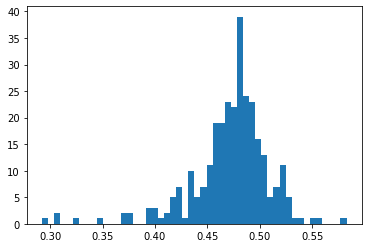

0.4717093896312033

In [20]:
plt.hist(tanks_data['tank_winrate'], bins=50)
plt.show()

tanks_data['tank_winrate'].mean()

In [21]:
data = data.merge(tanks_data[['tank_winrate']], how='left', on='vehicle_type_cd')
data

,dt,arena_id,account_db_id,team_id,clan_db_id,prebattle_id,is_prebattle_creator,vehicle_type_cd,life_time_sec,shots,...,daily_xp_factor,battle_num,damage_blocked_by_armor,booster_bonus_credits,booster_bonus_xp,is_alive,winner_team_id,is_winner,player_winrate_ML,tank_winrate
0,2018-10-27,4yNy14y4yN12d42dT,c42c4aydT,2,0,0,0,2849,132,3,...,20,11956,0,0,0,False,2.0,True,0.203866,0.459560
1,2018-10-27,4yNy14y4yN12d42dT,c2TaaayN4,1,500033550,0,0,63553,195,6,...,10,9832,0,0,0,False,2.0,False,0.402422,0.480320
2,2018-10-27,4yNy14y4yN12d42dT,cyyd47dc4,2,500051107,67896661,0,17665,224,11,...,20,39190,0,0,1130,False,2.0,True,0.579576,0.478992
3,2018-10-27,4yNy14y4yN12d42dT,c2cdc441y,2,0,0,0,11537,381,8,...,20,7217,0,0,0,True,2.0,True,0.488318,0.471584
4,2018-10-27,4yNy14y4yN12d42dT,cdT7cTT21,1,0,0,0,7937,198,5,...,10,9532,0,0,0,False,2.0,False,0.497079,0.470886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1400485,2018-10-11,1ccdcTcya4T7Nyc,cac4aa12N,2,500150344,5640480,0,1921,364,9,...,20,13638,0,0,0,True,NaN,False,0.410263,0.472595
1400486,2018-10-11,1ccdcTcya4T7Nyc,cdTcc72Nc,1,500138824,5288203,0,913,311,6,...,10,14741,760,0,0,False,NaN,False,0.375367,0.480080
1400487,2018-10-11,1ccdcTcya4T7Nyc,cd42c2TTT,1,500154303,5288203,0,50193,174,2,...,10,29797,0,0,0,False,NaN,False,0.502854,0.483483
1400488,2018-10-11,1ccdcTcya4T7Nyc,cd4a7Tc72,2,500156478,5640480,0,51361,136,7,...,10,41982,0,0,0,False,NaN,False,0.411648,0.466601


In [22]:
data.drop(columns=['dt', 'team_id', 'remained_hp', 'is_alive', 'winner_team_id', 'is_winner'], inplace=True, axis=1)
data

,arena_id,account_db_id,clan_db_id,prebattle_id,is_prebattle_creator,vehicle_type_cd,life_time_sec,shots,hits,he_hits,...,original_credits,original_xp,premium_xp_factor,daily_xp_factor,battle_num,damage_blocked_by_armor,booster_bonus_credits,booster_bonus_xp,player_winrate_ML,tank_winrate
0,4yNy14y4yN12d42dT,c42c4aydT,0,0,0,2849,132,3,2,0,...,27279,1084,15,20,11956,0,0,0,0.203866,0.459560
1,4yNy14y4yN12d42dT,c2TaaayN4,500033550,0,0,63553,195,6,3,0,...,6282,68,15,10,9832,0,0,0,0.402422,0.480320
2,4yNy14y4yN12d42dT,cyyd47dc4,500051107,67896661,0,17665,224,11,10,0,...,36102,3560,15,20,39190,0,0,1130,0.579576,0.478992
3,4yNy14y4yN12d42dT,c2cdc441y,0,0,0,11537,381,8,5,0,...,16317,1678,15,20,7217,0,0,0,0.488318,0.471584
4,4yNy14y4yN12d42dT,cdT7cTT21,0,0,0,7937,198,5,3,0,...,11620,232,15,10,9532,0,0,0,0.497079,0.470886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1400485,1ccdcTcya4T7Nyc,cac4aa12N,500150344,5640480,0,1921,364,9,6,0,...,77063,2532,15,20,13638,0,0,0,0.410263,0.472595
1400486,1ccdcTcya4T7Nyc,cdTcc72Nc,500138824,5288203,0,913,311,6,5,0,...,34367,294,15,10,14741,760,0,0,0.375367,0.480080
1400487,1ccdcTcya4T7Nyc,cd42c2TTT,500154303,5288203,0,50193,174,2,1,0,...,10361,90,15,10,29797,0,0,0,0.502854,0.483483
1400488,1ccdcTcya4T7Nyc,cd4a7Tc72,500156478,5640480,0,51361,136,7,6,0,...,48382,740,15,10,41982,0,0,0,0.411648,0.466601


# Creating new features

In [23]:
def normalize_feature(target_feature, norm_feature):
    if norm_feature != 0:
        return target_feature / norm_feature
    else:
        return 0

normalize_feature = np.vectorize(normalize_feature)

In [24]:
f = data.groupby(['vehicle_type_cd', 'account_db_id'])[['damage_dealt',
                                                        'damage_assisted_radio',
                                                        'damage_assisted_track',
                                                        'damage_blocked_by_armor',
                                                        'player_winrate_ML']].mean()

f['normed_damage_dealt'] = (1 - f['player_winrate_ML']) * f['damage_dealt']
f['normed_damage_assisted_radio'] = (1 - f['player_winrate_ML']) * f['damage_assisted_radio']
f['normed_damage_assisted_track'] = (1 - f['player_winrate_ML']) * f['damage_assisted_track']
f['normed_damage_blocked_by_armor'] = (1 - f['player_winrate_ML']) * f['damage_blocked_by_armor']

f = f.groupby(level=0)[['normed_damage_dealt', 'normed_damage_assisted_radio',
                        'normed_damage_assisted_track', 'normed_damage_blocked_by_armor']].mean()

f

,normed_damage_dealt,normed_damage_assisted_radio,normed_damage_assisted_track,normed_damage_blocked_by_armor
vehicle_type_cd,,,,
49,473.311940,213.803887,40.479473,228.413618
273,337.862176,12.076085,20.276587,0.192085
305,290.184809,300.688147,18.686263,10.580035
513,323.440942,116.764366,26.163492,144.124431
529,316.996152,128.503473,31.162409,107.751517
...,...,...,...,...
64065,477.744454,177.581066,37.687502,109.060262
64273,383.299162,184.913121,29.529026,63.764429
64561,465.103591,166.660491,35.486556,534.556380


In [25]:
data = data.merge(catalog, how='left', left_on='vehicle_type_cd', right_on='item_cd')
data.drop(['item_cd'], axis=1, inplace=True)
data

,arena_id,account_db_id,clan_db_id,prebattle_id,is_prebattle_creator,vehicle_type_cd,life_time_sec,shots,hits,he_hits,...,damage_blocked_by_armor,booster_bonus_credits,booster_bonus_xp,player_winrate_ML,tank_winrate,item_class,item_price_credit,item_price_gold,item_level,crew_size
0,4yNy14y4yN12d42dT,c42c4aydT,0,0,0,2849,132,3,2,0,...,0,0,0,0.203866,0.459560,2,0,12000,8,6
1,4yNy14y4yN12d42dT,c2TaaayN4,500033550,0,0,63553,195,6,3,0,...,0,0,0,0.402422,0.480320,4,0,7450,8,4
2,4yNy14y4yN12d42dT,cyyd47dc4,500051107,67896661,0,17665,224,11,10,0,...,0,0,1130,0.579576,0.478992,4,3450000,0,9,4
3,4yNy14y4yN12d42dT,c2cdc441y,0,0,0,11537,381,8,5,0,...,0,0,0,0.488318,0.471584,0,2570000,0,8,5
4,4yNy14y4yN12d42dT,cdT7cTT21,0,0,0,7937,198,5,3,0,...,0,0,0,0.497079,0.470886,4,3450000,0,9,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1400485,1ccdcTcya4T7Nyc,cac4aa12N,500150344,5640480,0,1921,364,9,6,0,...,0,0,0,0.410263,0.472595,2,2540000,0,8,3
1400486,1ccdcTcya4T7Nyc,cdTcc72Nc,500138824,5288203,0,913,311,6,5,0,...,760,0,0,0.375367,0.480080,2,0,10700,8,4
1400487,1ccdcTcya4T7Nyc,cd42c2TTT,500154303,5288203,0,50193,174,2,1,0,...,0,0,0,0.502854,0.483483,0,0,10900,8,4
1400488,1ccdcTcya4T7Nyc,cd4a7Tc72,500156478,5640480,0,51361,136,7,6,0,...,0,0,0,0.411648,0.466601,4,0,11000,8,4


In [26]:
data = data.merge(f, how='left', on='vehicle_type_cd')
data

,arena_id,account_db_id,clan_db_id,prebattle_id,is_prebattle_creator,vehicle_type_cd,life_time_sec,shots,hits,he_hits,...,tank_winrate,item_class,item_price_credit,item_price_gold,item_level,crew_size,normed_damage_dealt,normed_damage_assisted_radio,normed_damage_assisted_track,normed_damage_blocked_by_armor
0,4yNy14y4yN12d42dT,c42c4aydT,0,0,0,2849,132,3,2,0,...,0.459560,2,0,12000,8,6,466.213560,139.309015,26.504361,289.614058
1,4yNy14y4yN12d42dT,c2TaaayN4,500033550,0,0,63553,195,6,3,0,...,0.480320,4,0,7450,8,4,416.201057,186.414947,30.666480,6.709073
2,4yNy14y4yN12d42dT,cyyd47dc4,500051107,67896661,0,17665,224,11,10,0,...,0.478992,4,3450000,0,9,4,731.789429,221.153018,42.584407,161.936210
3,4yNy14y4yN12d42dT,c2cdc441y,0,0,0,11537,381,8,5,0,...,0.471584,0,2570000,0,8,5,510.044793,95.585101,27.080273,125.572412
4,4yNy14y4yN12d42dT,cdT7cTT21,0,0,0,7937,198,5,3,0,...,0.470886,4,3450000,0,9,4,653.867294,245.762713,45.855045,315.715939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1400485,1ccdcTcya4T7Nyc,cac4aa12N,500150344,5640480,0,1921,364,9,6,0,...,0.472595,2,2540000,0,8,3,531.136783,139.877438,40.939149,199.777550
1400486,1ccdcTcya4T7Nyc,cdTcc72Nc,500138824,5288203,0,913,311,6,5,0,...,0.480080,2,0,10700,8,4,576.015490,153.850898,32.614319,381.753689
1400487,1ccdcTcya4T7Nyc,cd42c2TTT,500154303,5288203,0,50193,174,2,1,0,...,0.483483,0,0,10900,8,4,624.302262,93.643866,27.721128,1.818655
1400488,1ccdcTcya4T7Nyc,cd4a7Tc72,500156478,5640480,0,51361,136,7,6,0,...,0.466601,4,0,11000,8,4,607.372411,172.534704,43.080404,28.955581


In [28]:
dataset = data[['vehicle_type_cd', 'item_class', 'item_level', 'tank_winrate',
                'normed_damage_dealt', 'normed_damage_assisted_radio',
                'normed_damage_assisted_track', 'normed_damage_blocked_by_armor',
                'item_price_credit', 'item_price_gold']]
dataset

,vehicle_type_cd,item_class,item_level,tank_winrate,normed_damage_dealt,normed_damage_assisted_radio,normed_damage_assisted_track,normed_damage_blocked_by_armor,item_price_credit,item_price_gold
0,2849,2,8,0.459560,466.213560,139.309015,26.504361,289.614058,0,12000
1,63553,4,8,0.480320,416.201057,186.414947,30.666480,6.709073,0,7450
2,17665,4,9,0.478992,731.789429,221.153018,42.584407,161.936210,3450000,0
3,11537,0,8,0.471584,510.044793,95.585101,27.080273,125.572412,2570000,0
4,7937,4,9,0.470886,653.867294,245.762713,45.855045,315.715939,3450000,0
...,...,...,...,...,...,...,...,...,...,...
1400485,1921,2,8,0.472595,531.136783,139.877438,40.939149,199.777550,2540000,0
1400486,913,2,8,0.480080,576.015490,153.850898,32.614319,381.753689,0,10700
1400487,50193,0,8,0.483483,624.302262,93.643866,27.721128,1.818655,0,10900
1400488,51361,4,8,0.466601,607.372411,172.534704,43.080404,28.955581,0,11000


# Correlations

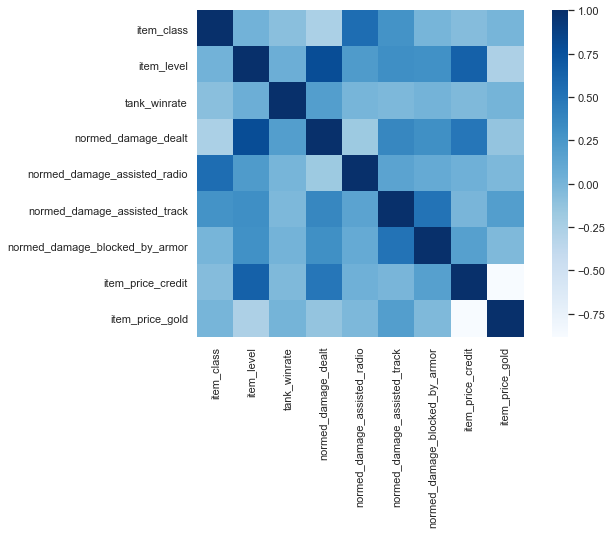

item_price_credit                -0.881308
item_level                       -0.262734
normed_damage_dealt              -0.124695
normed_damage_blocked_by_armor   -0.029959
normed_damage_assisted_radio     -0.024838
item_class                        0.007464
tank_winrate                      0.010490
normed_damage_assisted_track      0.192822
item_price_gold                   1.000000
Name: item_price_gold, dtype: float64

In [59]:
sns.set(font_scale=1)

corr = dataset.corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr, square=True, cmap='Blues')

plt.show()

corr['item_price_gold'].sort_values()

# Regression model

In [47]:
res_data = dataset.groupby('vehicle_type_cd').mean().reset_index()
tank_params = res_data[res_data['vehicle_type_cd'] == 9217]
res_data = res_data[res_data['vehicle_type_cd'] != 9217]

res_data.drop(columns=['vehicle_type_cd'], inplace=True, axis=1)

features = list(res_data.columns)
features.remove('item_price_credit'); features.remove('item_price_gold')
target_credit = ['item_price_credit']
target_gold = ['item_price_gold']

credit_dataset = res_data[res_data['item_price_credit'] != 0][features + target_credit]
gold_dataset = res_data[res_data['item_price_gold'] != 0][features + target_gold]

credit_dataset.index = np.arange(len(credit_dataset))
gold_dataset.index = np.arange(len(gold_dataset))

gold_dataset

,item_class,item_level,tank_winrate,normed_damage_dealt,normed_damage_assisted_radio,normed_damage_assisted_track,normed_damage_blocked_by_armor,item_price_gold
0,4,8,0.491997,473.311940,213.803887,40.479473,228.413618,7500
1,3,7,0.529582,290.184809,300.688147,18.686263,10.580035,4800
2,2,8,0.499892,505.762407,179.769190,38.609538,409.051085,12250
3,2,8,0.480080,576.015490,153.850898,32.614319,381.753689,10700
4,2,8,0.459560,466.213560,139.309015,26.504361,289.614058,12000
...,...,...,...,...,...,...,...,...
74,2,8,0.500320,477.744454,177.581066,37.687502,109.060262,11900
75,4,8,0.447225,383.299162,184.913121,29.529026,63.764429,8700
76,2,8,0.494363,465.103591,166.660491,35.486556,534.556380,10500
77,3,6,0.309820,217.219396,187.923414,9.584958,0.703981,3500


In [48]:
credit_scaler = StandardScaler()
gold_scaler = StandardScaler()

normed_credit_dataset = pd.DataFrame(credit_scaler.fit_transform(credit_dataset), columns=[features + target_credit])
normed_gold_dataset = pd.DataFrame(gold_scaler.fit_transform(gold_dataset), columns=[features + target_gold])

normed_gold_dataset

,item_class,item_level,tank_winrate,normed_damage_dealt,normed_damage_assisted_radio,normed_damage_assisted_track,normed_damage_blocked_by_armor,item_price_gold
0,1.084885,0.421520,0.347659,0.067063,0.617278,0.575705,0.094948,-0.428245
1,0.393708,-1.164199,1.260345,-1.138339,1.992978,-0.986742,-1.055912,-1.291288
2,-0.297468,0.421520,0.539395,0.280663,0.078383,0.441641,1.049294,1.090073
3,-0.297468,0.421520,0.058287,0.743091,-0.331999,0.011819,0.905076,0.594622
4,-0.297468,0.421520,-0.440005,0.020339,-0.562251,-0.426230,0.418283,1.010162
...,...,...,...,...,...,...,...,...
74,-0.297468,0.421520,0.549777,0.096239,0.043737,0.375537,-0.535621,0.978197
75,1.084885,0.421520,-0.739534,-0.525430,0.159831,-0.209379,-0.774928,-0.044669
76,-0.297468,0.421520,0.405116,0.013033,-0.129176,0.217742,1.712365,0.530693
77,0.393708,-2.749918,-4.076177,-1.618621,0.207495,-1.639253,-1.108089,-1.706828


In [49]:
train_data = np.array(normed_gold_dataset.drop(columns=['item_price_gold']))
train_labels = np.array(normed_gold_dataset[['item_price_gold']])

c:\users\egor\appdata\local\programs\python\python37\lib\site-packages\pandas\core\generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [50]:
epochs = 100

model = build_model(train_data.shape[1])
history = model.fit(train_data, train_labels,
                    validation_split=0.15,
                    epochs=epochs, shuffle=True)

Train on 67 samples, validate on 12 samples
Epoch 1/100
67/67 [==============================] - 1s 10ms/sample - loss: 1.4660 - val_loss: 0.3822
Epoch 2/100
67/67 [==============================] - 0s 461us/sample - loss: 0.9575 - val_loss: 0.3362
Epoch 3/100
67/67 [==============================] - 0s 357us/sample - loss: 0.8077 - val_loss: 0.2880
Epoch 4/100
67/67 [==============================] - 0s 319us/sample - loss: 0.7171 - val_loss: 0.2603
Epoch 5/100
67/67 [==============================] - 0s 298us/sample - loss: 0.5411 - val_loss: 0.2642
Epoch 6/100
67/67 [==============================] - 0s 253us/sample - loss: 0.5807 - val_loss: 0.2490
Epoch 7/100
67/67 [==============================] - 0s 342us/sample - loss: 0.5019 - val_loss: 0.2558
Epoch 8/100
67/67 [==============================] - 0s 328us/sample - loss: 0.4532 - val_loss: 0.2497
Epoch 9/100
67/67 [==============================] - 0s 298us/sample - loss: 0.5393 - val_loss: 0.2318
Epoch 10/100
67/67 [==========

67/67 [==============================] - 0s 298us/sample - loss: 0.0728 - val_loss: 0.1007
Epoch 80/100
67/67 [==============================] - 0s 342us/sample - loss: 0.0575 - val_loss: 0.1261
Epoch 81/100
67/67 [==============================] - 0s 313us/sample - loss: 0.0750 - val_loss: 0.1221
Epoch 82/100
67/67 [==============================] - 0s 283us/sample - loss: 0.0686 - val_loss: 0.1224
Epoch 83/100
67/67 [==============================] - 0s 268us/sample - loss: 0.1135 - val_loss: 0.1404
Epoch 84/100
67/67 [==============================] - 0s 283us/sample - loss: 0.0685 - val_loss: 0.1325
Epoch 85/100
67/67 [==============================] - 0s 268us/sample - loss: 0.0645 - val_loss: 0.1038
Epoch 86/100
67/67 [==============================] - 0s 313us/sample - loss: 0.1049 - val_loss: 0.1230
Epoch 87/100
67/67 [==============================] - 0s 283us/sample - loss: 0.0568 - val_loss: 0.1241
Epoch 88/100
67/67 [==============================] - 0s 268us/sample - loss:

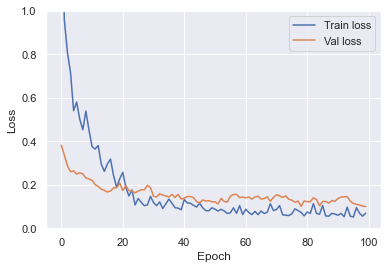

In [51]:
plot_history(model)

In [52]:
full_model = build_model(train_data.shape[1])
history = full_model.fit(train_data, train_labels,
                         epochs=100, shuffle=True)

Train on 79 samples
Epoch 1/100
79/79 [==============================] - 1s 7ms/sample - loss: 0.7230
Epoch 2/100
79/79 [==============================] - 0s 139us/sample - loss: 0.5284
Epoch 3/100
79/79 [==============================] - 0s 101us/sample - loss: 0.4039
Epoch 4/100
79/79 [==============================] - 0s 114us/sample - loss: 0.3612
Epoch 5/100
79/79 [==============================] - 0s 126us/sample - loss: 0.3136
Epoch 6/100
79/79 [==============================] - 0s 152us/sample - loss: 0.2892
Epoch 7/100
79/79 [==============================] - 0s 88us/sample - loss: 0.2734
Epoch 8/100
79/79 [==============================] - 0s 126us/sample - loss: 0.2386
Epoch 9/100
79/79 [==============================] - 0s 126us/sample - loss: 0.2256
Epoch 10/100
79/79 [==============================] - 0s 139us/sample - loss: 0.2332
Epoch 11/100
79/79 [==============================] - 0s 88us/sample - loss: 0.2066
Epoch 12/100
79/79 [==============================] - 0s 1

79/79 [==============================] - 0s 114us/sample - loss: 0.0524
Epoch 98/100
79/79 [==============================] - 0s 139us/sample - loss: 0.0533
Epoch 99/100
79/79 [==============================] - 0s 101us/sample - loss: 0.0701
Epoch 100/100
79/79 [==============================] - 0s 151us/sample - loss: 0.0484


In [ ]:
tank_params.drop(columns=['vehicle_type_cd', 'item_price_credit', 'item_price_gold'], inplace=True, axis=1)
tank_params

In [58]:
def predict(tank_params):
    tank_params['item_price_gold'] = 0
    
    scaled = gold_scaler.transform(tank_params)[:,:len(tank_params.columns) - 1]
    
    pred_full = full_model.predict(scaled)
    pred = model.predict(scaled)
    
    x_full = np.concatenate((scaled[0], pred_full[0]))
    x = np.concatenate((scaled[0], pred[0]))
    
    return gold_scaler.inverse_transform(x_full)[-1], gold_scaler.inverse_transform(x)[-1]

predict(tank_params)

(10998.638243925394, 10742.453174891942)

# Tests

In [ ]:
damage = data[data['vehicle_type_cd'] == 9217][['account_db_id', 'damage_dealt', 'player_winrate_ML']]
damage = damage[damage.groupby('account_db_id')['account_db_id'].transform('count') >= 5]

pl = damage.groupby('account_db_id').agg({'damage_dealt' : lambda g: g.mean(),
                                          'player_winrate_ML' : 'mean'})
pl['normed'] = (1 - pl['player_winrate_ML']) * pl['damage_dealt']

plt.hist(pl['normed'], bins=100)
plt.show()